<a href="https://colab.research.google.com/github/talhaMah56/MMST-ViT/blob/main/HW6/dtw_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You will need a few unusual libraries

In [1]:
!pip install python_speech_features
!pip install PyGithub
!pip install pydub

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=bc56a699dc96944dcca334f8f24107c1feb7cdbb221a30eea3ccf48484eb1d35
  Stored in directory: /root/.cache/pip/wheels/37/01/19/e6c69a32684ab7b2e3ea4985a571d810cf055c72600e7f9f17
Successfully built python_speech_features
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 25.8 MB/s eta 0:00:00


In [2]:
#system options you will need
import sys
import os
import numpy as np
import glob as glob

import scipy.io.wavfile as wav
from python_speech_features import mfcc
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from scipy.spatial.distance import cdist, euclidean
from scipy.spatial import distance_matrix

import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
np.set_printoptions(threshold=sys.maxsize)
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [29]:
cd /content/gdrive/My\ Drive/


/content/gdrive/My Drive


In [34]:
cd /data

/data


# I am going to download data from someone's github repo
One of you asked me earlier in the semester how one would so this. We will use data from Salika Dave, a student at Mumbai tech who stored some soundbites on her GitHub repo.

In [35]:
from github import Github
# First create a Github instance:
# we do not need to use username and password because we will access a public repo
g = Github()



In [36]:
guser = g.get_user("salik-a")
repo = guser.get_repo("Speech_Recognition")


In [37]:
wavfiles = repo.get_contents("voices")
#.repos_url#("Speech_Recognition")
wavfiles

[ContentFile(path="voices/Jarvis_template.wav"),
 ContentFile(path="voices/Jarvisd_template.wav"),
 ContentFile(path="voices/Jarvise_template.wav"),
 ContentFile(path="voices/Jarvish_template.wav"),
 ContentFile(path="voices/Jarvisu_template.wav"),
 ContentFile(path="voices/Tofftl_template.wav"),
 ContentFile(path="voices/Tofftld_template.wav"),
 ContentFile(path="voices/Tofftle_template.wav"),
 ContentFile(path="voices/Tofftlh_template.wav"),
 ContentFile(path="voices/Tofftlu_template.wav"),
 ContentFile(path="voices/Tontl_template.wav"),
 ContentFile(path="voices/Tontld_template.wav"),
 ContentFile(path="voices/Tontle_template.wav"),
 ContentFile(path="voices/Tontlh_template.wav"),
 ContentFile(path="voices/Tontlu_template.wav"),
 ContentFile(path="voices/Tontt_template.wav"),
 ContentFile(path="voices/Tonttd_template.wav"),
 ContentFile(path="voices/Tontte_template.wav"),
 ContentFile(path="voices/Tontth_template.wav"),
 ContentFile(path="voices/Tonttu_template.wav"),
 ContentFile(p

In [38]:
path = "https://raw.githubusercontent.com/salik-a/Speech_Recognition/master/"
for f in wavfiles:
    cmd = "wget " + "%s/%s"%(path,f.path)
    os.system(cmd)

In [45]:
%ls

Jarvisd_template.wav    Tofftl_template.wav.1   Tontth_template.wav
Jarvisd_template.wav.1  Tofftlu_template.wav    Tontth_template.wav.1
Jarvise_template.wav    Tofftlu_template.wav.1  Tontt_template.wav
Jarvise_template.wav.1  Tontld_template.wav     Tontt_template.wav.1
Jarvish_template.wav    Tontld_template.wav.1   Tonttu_template.wav
Jarvish_template.wav.1  Tontle_template.wav     Tonttu_template.wav.1
Jarvis_template.wav     Tontle_template.wav.1   Ttatd_template.wav
Jarvis_template.wav.1   Tontlh_template.wav     Ttatd_template.wav.1
Jarvisu_template.wav    Tontlh_template.wav.1   Ttate_template.wav
Jarvisu_template.wav.1  Tontl_template.wav      Ttate_template.wav.1
Tofftld_template.wav    Tontl_template.wav.1    Ttath_template.wav
Tofftld_template.wav.1  Tontlu_template.wav     Ttath_template.wav.1
Tofftle_template.wav    Tontlu_template.wav.1   Ttat_template.wav
Tofftle_template.wav.1  Tonttd_template.wav     Ttat_template.wav.1
Tofftlh_template.wav    Tonttd_template.wav.1 

In [50]:
cd ../

/


In [54]:
filenames = np.sort(glob.glob("data/*wav"))
norm_obj= Normalize(vmin=0, vmax=4)
colors = {"Jarvis": (pl.cm.viridis(norm_obj(0)),
                     "Jarvis"),
         "Tofftl": (pl.cm.viridis(norm_obj(1)),
                    "Turn off the lights"),
         "Tontl": (pl.cm.viridis(norm_obj(2)),
                   "Turn on the lights"),
         "Tontt": (pl.cm.viridis(norm_obj(3)),
                   "Turn on the TV"),
         "Ttat": (pl.cm.viridis(norm_obj(4)),
                  "Turn the air temperature")}
y = np.array([[k for k,v in colors.items() for i in range(5)]])[0]
y

array(['Jarvis', 'Jarvis', 'Jarvis', 'Jarvis', 'Jarvis', 'Tofftl',
       'Tofftl', 'Tofftl', 'Tofftl', 'Tofftl', 'Tontl', 'Tontl', 'Tontl',
       'Tontl', 'Tontl', 'Tontt', 'Tontt', 'Tontt', 'Tontt', 'Tontt',
       'Ttat', 'Ttat', 'Ttat', 'Ttat', 'Ttat'], dtype='<U6')

In [55]:
for k,v in colors.items():
        print(k,v)

Jarvis ((np.float64(0.267004), np.float64(0.004874), np.float64(0.329415), np.float64(1.0)), 'Jarvis')
Tofftl ((np.float64(0.229739), np.float64(0.322361), np.float64(0.545706), np.float64(1.0)), 'Turn off the lights')
Tontl ((np.float64(0.127568), np.float64(0.566949), np.float64(0.550556), np.float64(1.0)), 'Turn on the lights')
Tontt ((np.float64(0.369214), np.float64(0.788888), np.float64(0.382914), np.float64(1.0)), 'Turn on the TV')
Ttat ((np.float64(0.993248), np.float64(0.906157), np.float64(0.143936), np.float64(1.0)), 'Turn the air temperature')


#Data Exploration and Visualization
## plot the sound bites
the sound bites are read in as numpy array by the ```scipy.io.wavfile``` module. The dataset is comprised of 5 soundbites for each of 5 sentences. The word "Jarvis", the sentences "Turn off the lights", "Turn on the lights", "Turn on the TV", and "Turn the air temperature". Each sound bite, for each sentence, is read by a different person, with different accents, genders, and background noise. if you install the pydub  module and run the notebook locally you can hear each soundbite in this loop (wont play on google colab).

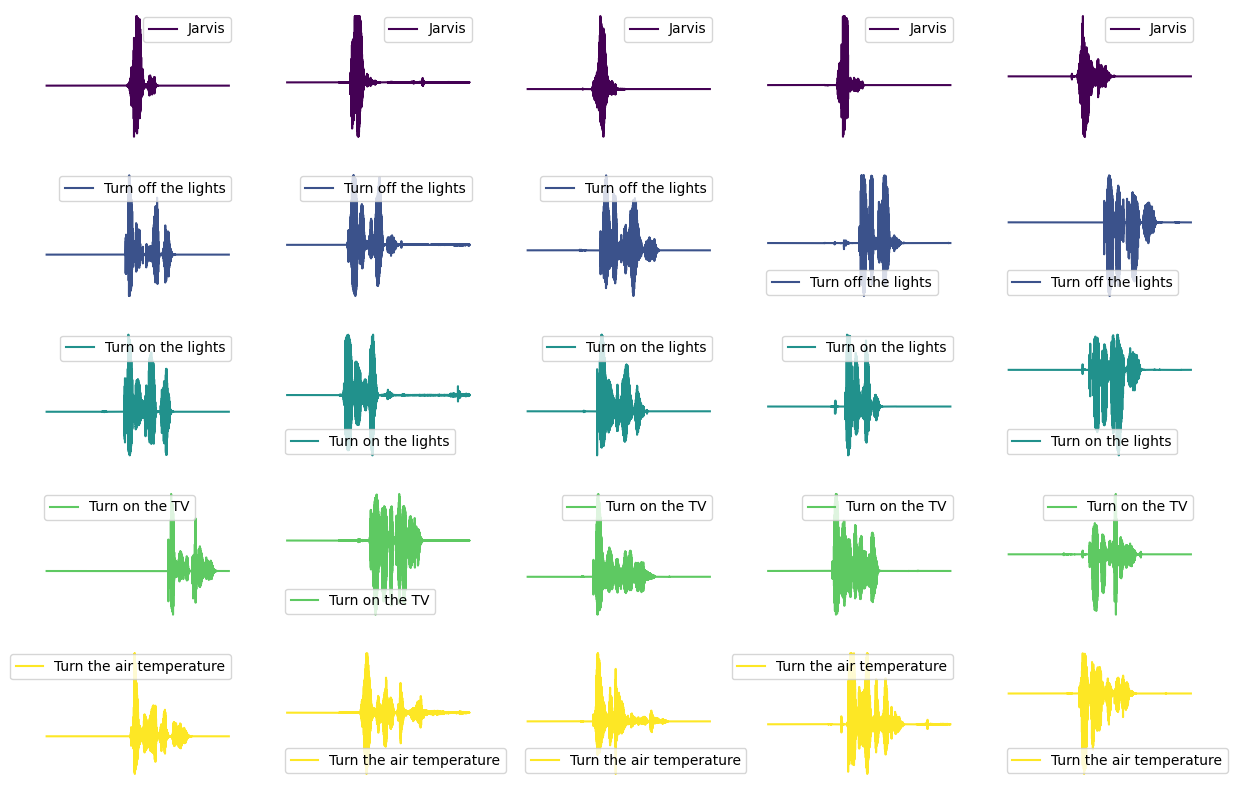

In [57]:
fig = pl.figure(figsize(15, 10))
wavfiles = []
from pydub import AudioSegment
from pydub.playback import play
for i,f in enumerate(filenames):
    ax = fig.add_subplot(5,5,i+1)
    phrase = AudioSegment.from_wav(f)
    play(phrase)
    wavfiles.append(wav.read(f))
    for k,v in colors.items():
        if k in f:
            color = colors[k][0]
            label = colors[k][1]
    ax.plot(wavfiles[-1][1], label=label, color=color)
    ax.axis('off')
    pl.legend()

Figure 1: 25 sound bites read in as arrays from the original *.wav* file. The arrays represnet sound intensity *vs* time, but the spectral sound information (frequency) is lost.  These are therefore simplified representations of the original data.
Each of 5 sentences is recorded as spoken by a different person in a different environment: the word "Jarvis", the sentences "Turn off the lights", "Turn on the lights", "Turn on the TV", and "Turn the air temperature".  In the above plot, each row is a different sentence (also plotted with a different color). The content of the soundbite is written on top of the wave plot.  At a glance, the soundbites show some similarities within the same sentence, mostly in the duration of the speech. We also note that the starting point of the speech is not homogeneous within the recorded segment.

The following analysis could be implemented in the full spectral-features dataset, but the current 1-dimensional representation of the data alows for a simpler implementation of the methods.

In [58]:
wavfiles = np.array([w[1] for w in wavfiles])
print ("the size of the full data set is :", wavfiles.shape)

the size of the full data set is : (25, 64000)


## downsampling the large arrays
each sound bit is stored in an array of 64000 elements. To work effectively we will downsample them by a factor of 10. Occasionally I will downsample it further.

Since classifying these sound mites will require generating distance arrays, we want to know ahead of time what we are getting ourelves into. We are working with foating point numbers
- 64 bits per number
We want to build 2D arrays that are NxN sized where N is the length of the soundbite array (64,000)
- 64000x64000
- 1 GB is 8e9 bit
## *task 1: Print out the amount of memory in Gigabytes (or Megabytes where needed) that would take to create a single distance matrix, a distance matrix subsampling the array by 10, by 8, and by 100*

In [60]:
print("calculating a distance matrix for the full files would requires " +
      f"{wavfiles[0].shape[0]**2*64/8e9} GB of memory")
print("subsampling by a factor 10 requires " +
      f"{wavfiles[0][::8].shape[0]**2*64/8e9} GB of memory")
print("subsampling by a factor 10 requires " +
      f"{wavfiles[0][::10].shape[0]**2*64/8e9} GB of memory")
print("subsampling by a factor 100 requires " +
      f"{wavfiles[0][::100].shape[0]**2*64/8e6} MB of memory")

calculating a distance matrix for the full files would requires 32.768 GB of memory
subsampling by a factor 10 requires 0.512 GB of memory
subsampling by a factor 10 requires 0.32768 GB of memory
subsampling by a factor 100 requires 3.2768 MB of memory


In [62]:
steps = 10

In [63]:
X = preprocessing.scale(wavfiles[:,::steps], axis=1)

In [64]:
X.shape, X.std(axis=1)

((25, 6400),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]))

inspect the sound bites: the original array and the downsampled, normalized ones.

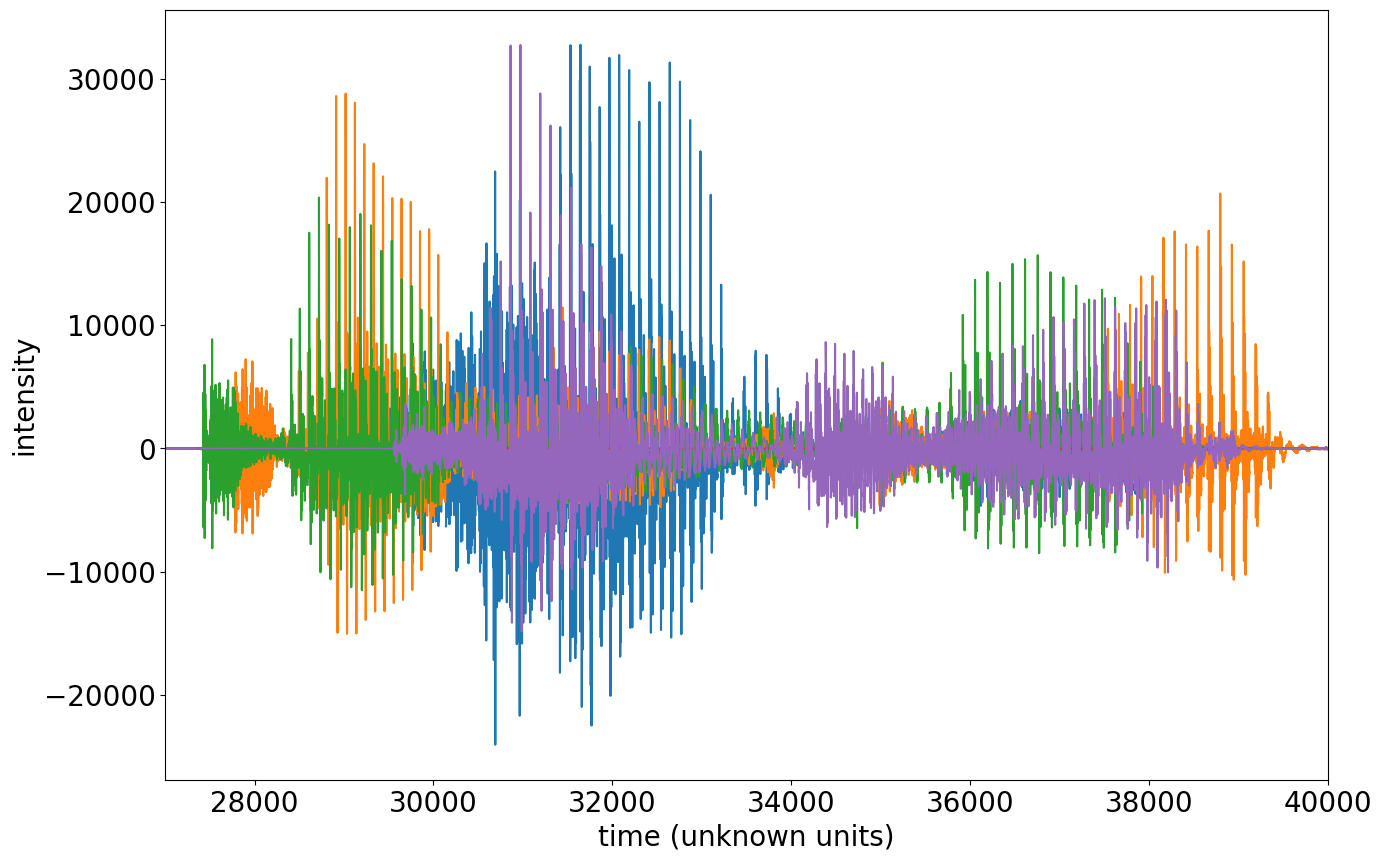

In [65]:
pl.rcParams['font.size'] = 20
pl.plot(wavfiles[0])
pl.plot(wavfiles[5])
pl.plot(wavfiles[10])
pl.plot(wavfiles[15])
pl.plot(wavfiles[20])
pl.xlim(27000, 40000)
pl.xlabel("time (unknown units)", fontsize=20)
pl.ylabel("intensity", fontsize=20);

Figure 2: the first sound bite for each sentene, the core portion of the array only is shown, elements 27000-40000 of 64000.


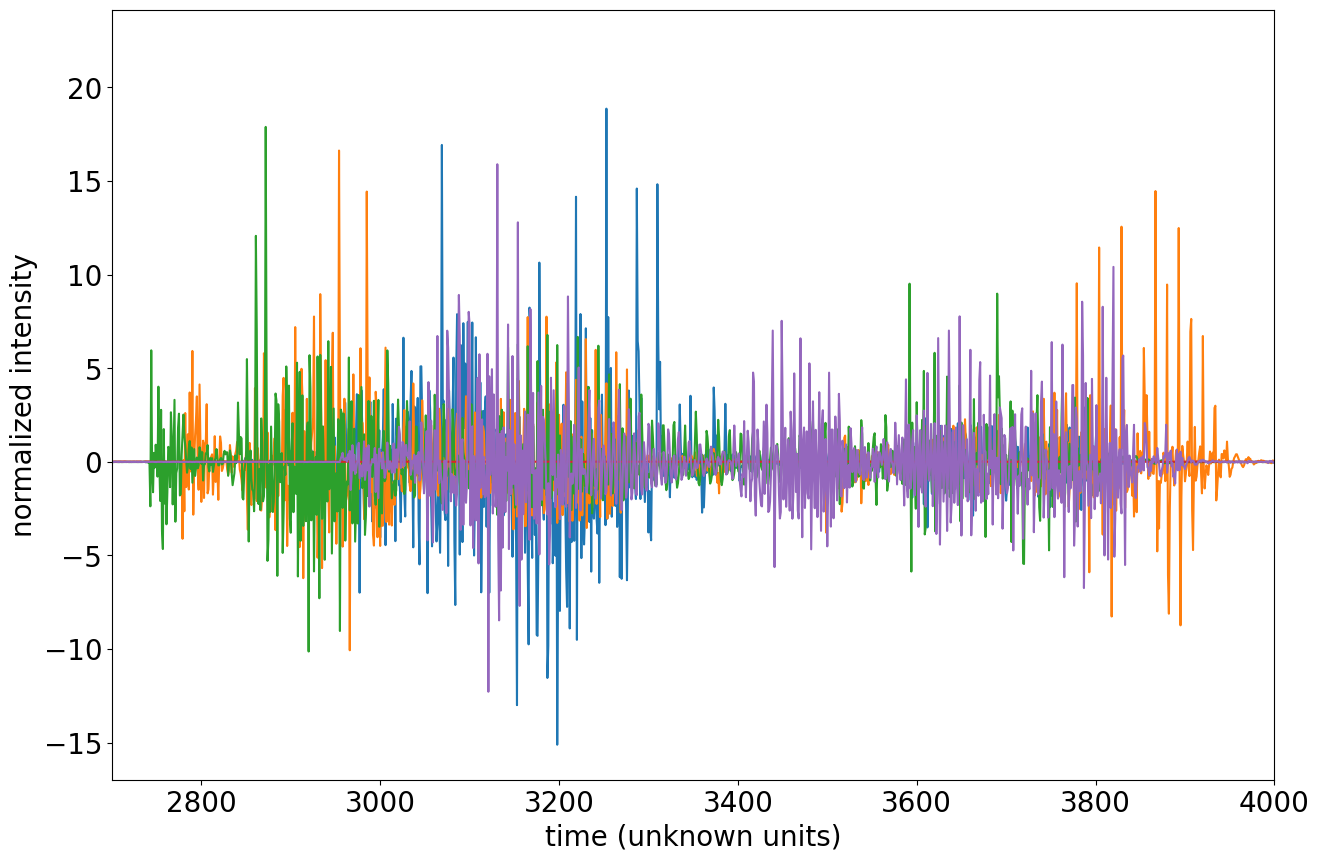

In [66]:
pl.rcParams['font.size'] = 20
pl.plot(X[0])
pl.plot(X[5])
pl.plot(X[10])
pl.plot(X[15])
pl.plot(X[20])
pl.xlim(2700, 4000)
pl.xlabel("time (unknown units)", fontsize=20)
pl.ylabel("normalized intensity", fontsize=20);

Figure 3: Same as figure 2 but for the standardized arrays, downsampled by a factor 10 by selecting every 10th datum.

# Calculating distance between sound bites
# Naive distsances between two arrays
Plot the distance between each pair of the 25 sound bites. The distance matrix should be 25x25 and each entry should be a naive distance calculated between the 2 arrays.

The naive distance can be the sum of the difference between entries of the array at the same time stamp, i.e. along the diagonal, or its absolute value, which would correspond to the L1 metric

In [67]:
def naive_distances(a, b):
    return (a - b).sum()
def l1(a, b):
    return (np.abs(a - b)).sum()

to save time I am resampling again by the same step. This is equivalent to resampling by 100

## *task 1: explain the figures*

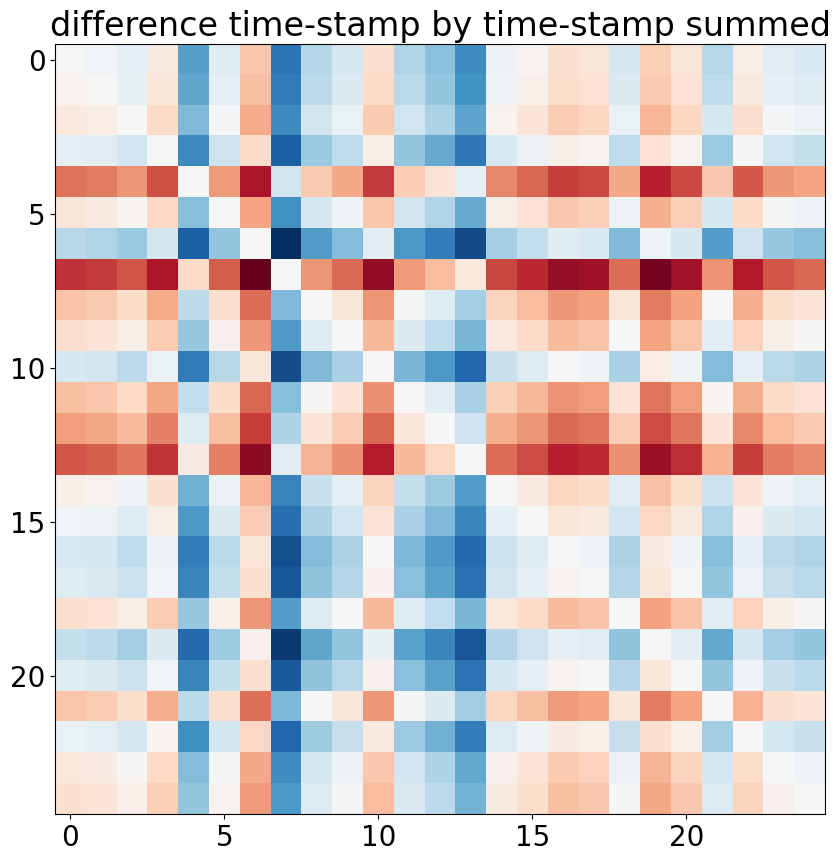

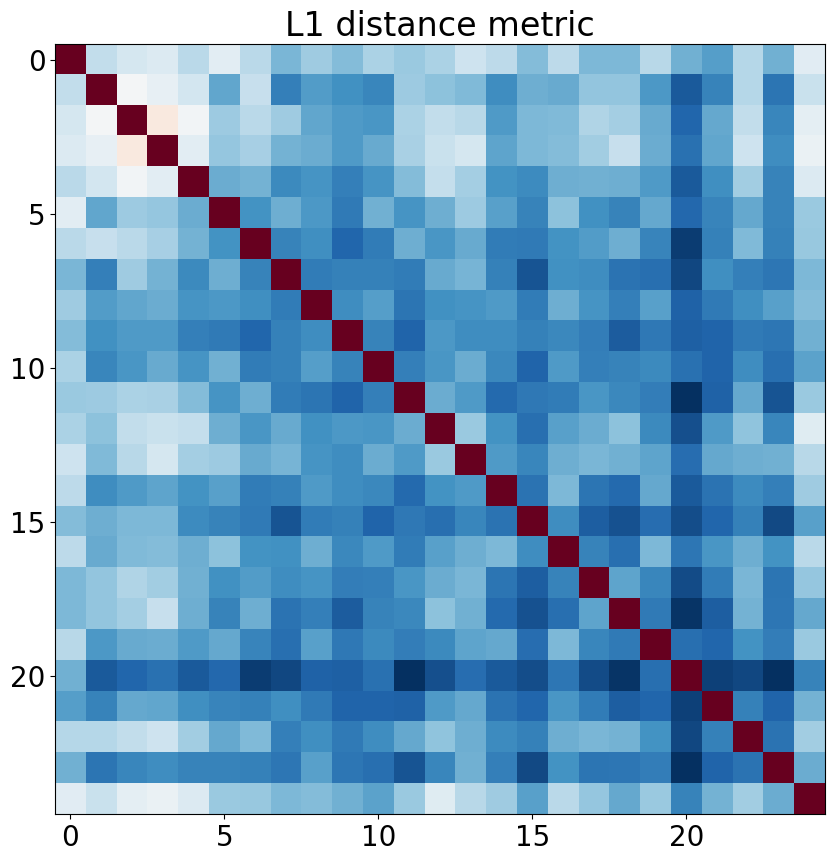

In [71]:
pl.imshow(cdist(X[:,::steps],
               X[:,::steps], metric=naive_distances),
         cmap="RdBu")
pl.title("difference time-stamp by time-stamp summed")
pl.figure()
pl.imshow(cdist(X[:,::steps],
               X[:,::steps], metric=l1),
         cmap="RdBu")
pl.title("L1 distance metric");

Figure 3: Distance matrices for time series using Naive (top) and L1 (bottom) metrics. Diagonal elements indicate self-distance (white for Naive, maroon for L1). The Naive matrix shows directional similarity differences (red/blue bands), while the L1 highlights a distinct sound bite at y=20 (darker blue).

# Pairwise time-stamps distance: each time series is a vector, so we can look at the timestamp-to-timestamp distance matrix

This is the object whose diagonal you summed over to get the naive distances and the L1 distances above.
For the full sample array this should be a 64000x64000 array. It is ok to calculate the distance and plot the stanradrized arrays, further downsampled by 10 (640x640 array)

use ```scipy.spatial.distance.cdist()``` and the L1 metric that was created earlier

## *task 2 comment on the following 2 figures*

Figure 3: Distance matrices for time series using Naive (top) and L1 (bottom) metrics. Diagonal elements indicate self-distance (white for Naive, maroon for L1). The Naive matrix shows directional similarity differences (red/blue bands), while the L1 highlights a distinct sound bite at y=20 (darker blue).

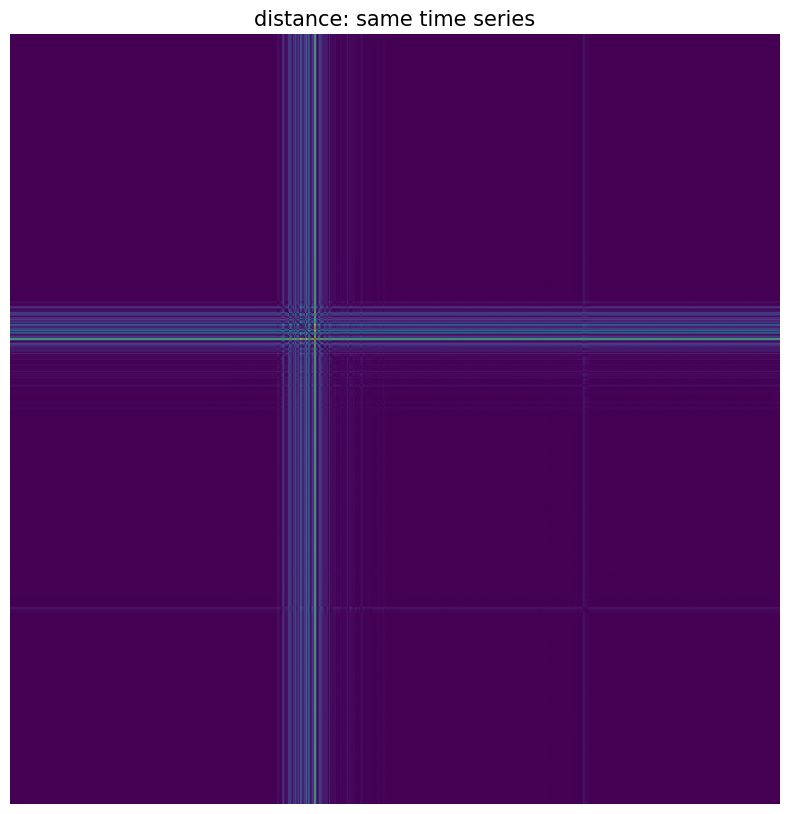

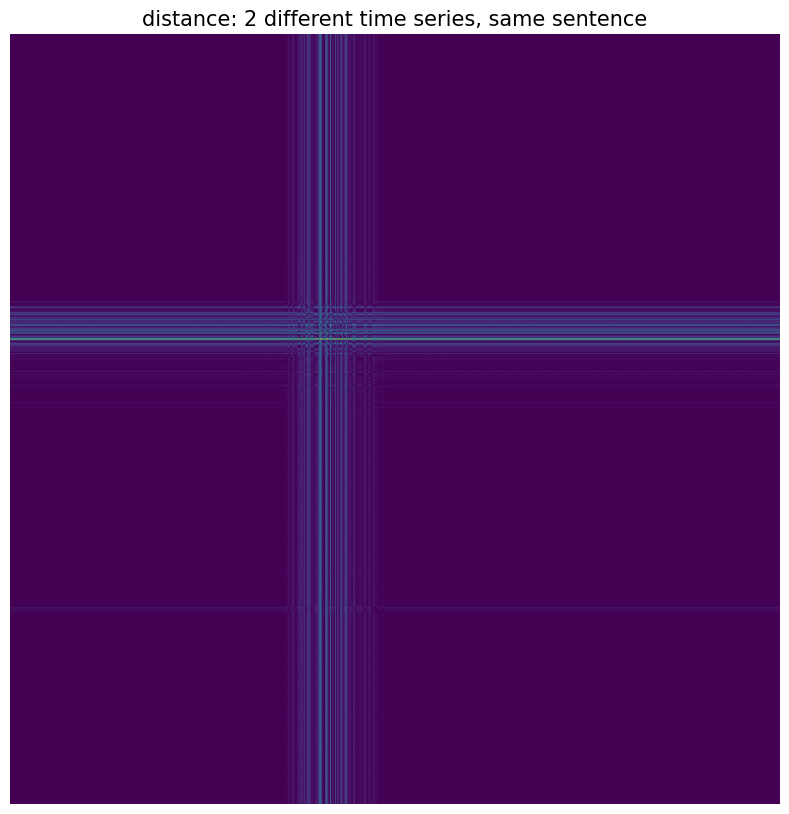

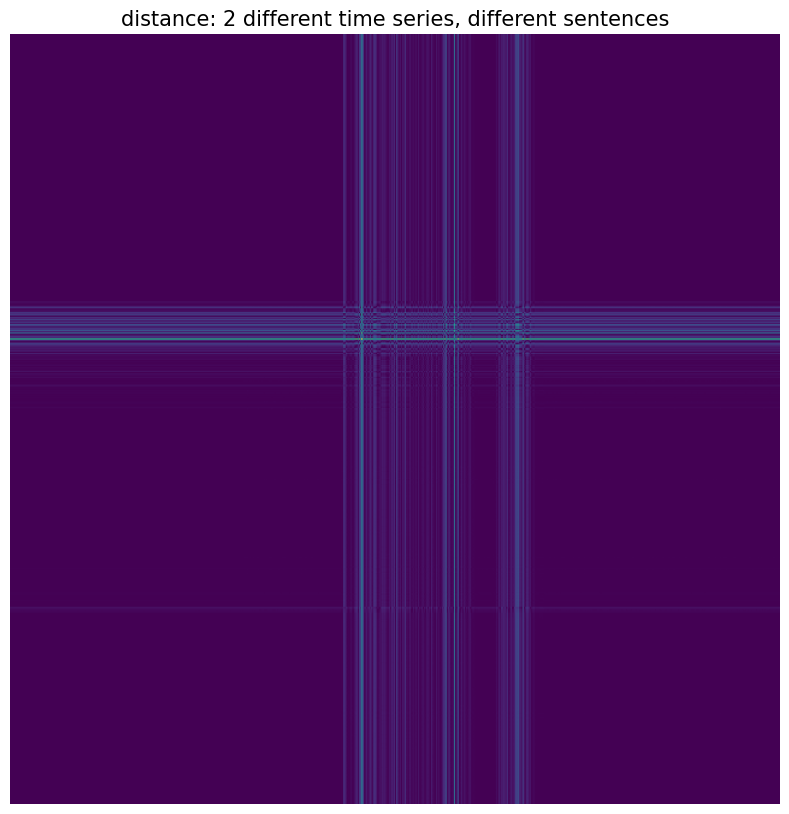

In [72]:
pl.imshow(cdist(np.atleast_2d(X[1][::steps]).T,
                np.atleast_2d(X[1][::steps]).T,
      metric=l1))
pl.title("distance: same time series", fontsize=15)
pl.axis('off')
pl.figure()
pl.imshow(cdist(np.atleast_2d(X[1][::steps]).T,
                np.atleast_2d(X[2][::steps]).T,
      metric=l1))
pl.title("distance: 2 different time series, same sentence", fontsize=15);
pl.axis('off')
pl.figure()
pl.imshow(cdist(np.atleast_2d(X[1][::steps]).T,
                np.atleast_2d(X[10][::steps]).T,
      metric=l1))
pl.title("distance: 2 different time series, different sentences",
         fontsize=15);
pl.axis('off');


Figure 4: L1 distance matrices for sound bites under varying conditions: same time series (top) with diagonal and similarity bands; same sentence (middle) and different sentences (bottom) show scattered bands. Purple areas denote no sound.

because it is very hard to tell whatis going on in the plots above let's replot with the color in logscale

<ipython-input-73-13fb4441c066>:1: RuntimeWarning: divide by zero encountered in log10
  pl.imshow(np.log10(cdist(np.atleast_2d(X[1][::steps]).T,


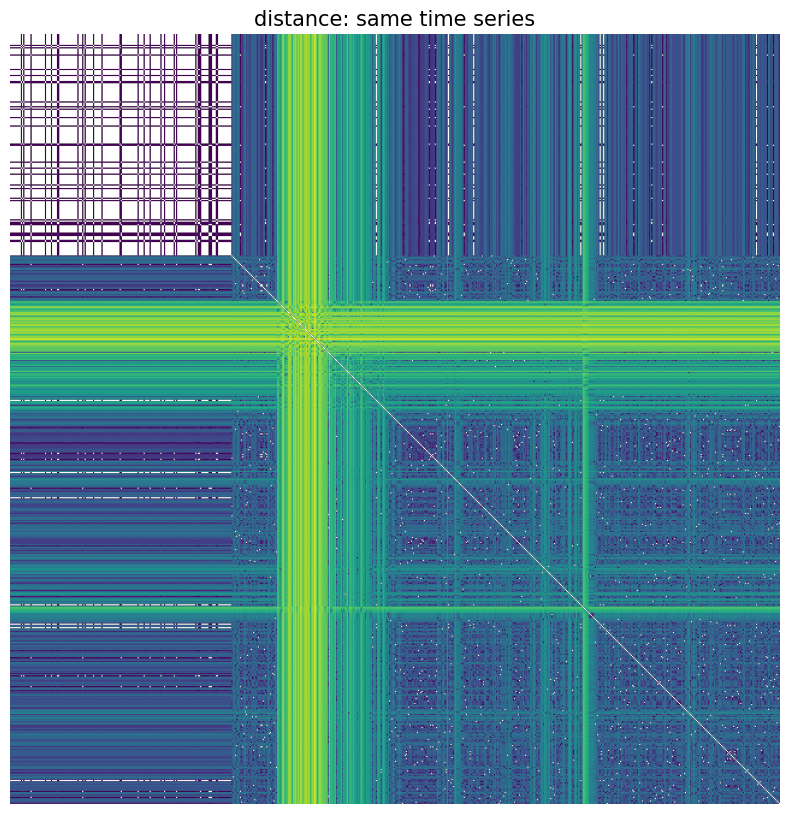

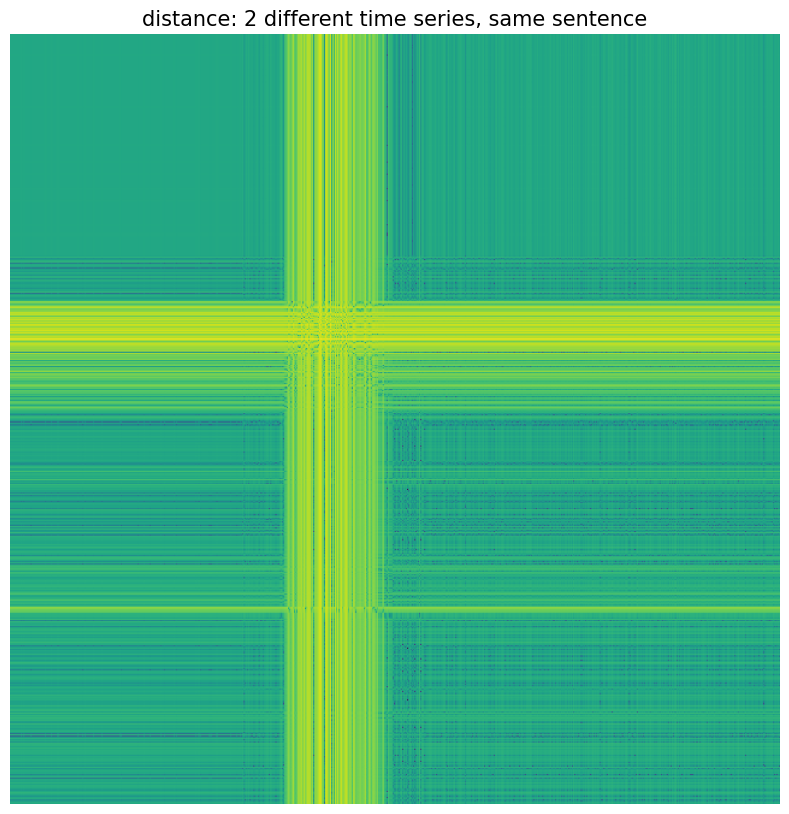

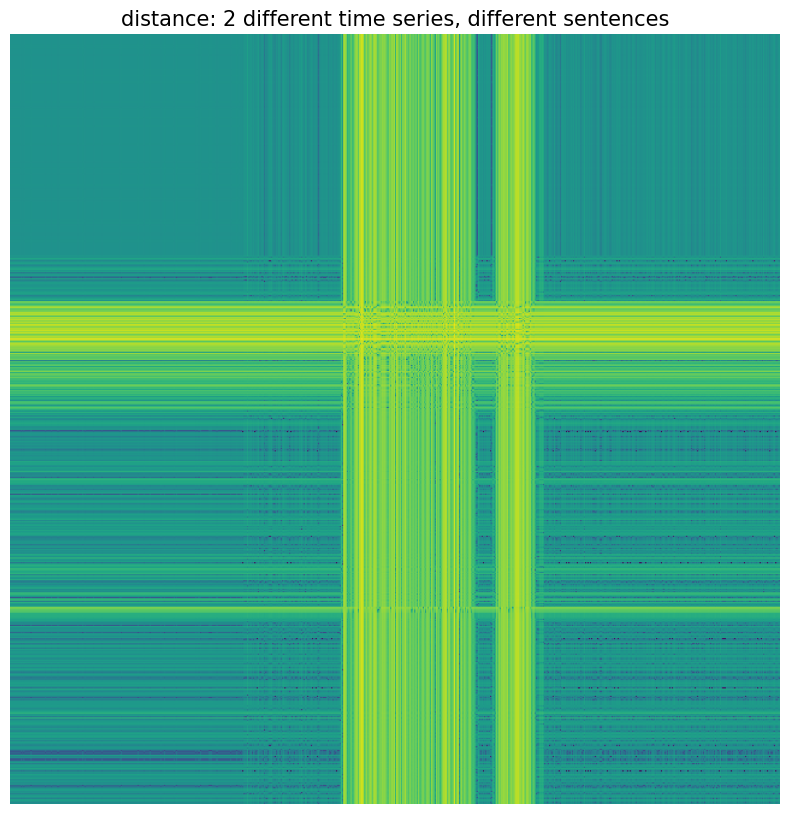

In [73]:
pl.imshow(np.log10(cdist(np.atleast_2d(X[1][::steps]).T,
                np.atleast_2d(X[1][::steps]).T,
      metric=l1)))
pl.title("distance: same time series", fontsize=15)
pl.axis('off')
pl.figure()
pl.imshow(np.log10(cdist(np.atleast_2d(X[1][::steps]).T,
                np.atleast_2d(X[2][::steps]).T,
      metric=l1)))
pl.title("distance: 2 different time series, same sentence", fontsize=15);
pl.axis('off')
pl.figure()
pl.imshow(np.log10(cdist(np.atleast_2d(X[1][::steps]).T,
                np.atleast_2d(X[10][::steps]).T,
      metric=l1)))
pl.title("distance: 2 different time series, different sentences",
         fontsize=15);
pl.axis('off');


Figure 5: L1 distance matrices in log₁₀ scale for same time series (top), same sentence (middle), and different sentences (bottom). Bright bands highlight sound bite similarities (e.g., "turn on/off" phrases); white diagonal denotes minimal self-distance. Logscale enhances visibility of patterns (e.g., cross bands) compared to linear-scale matrices (Fig. 4).

## Computing the distance between all pixel pairs is also prohibitively slow. Do doit I further resampled the array by another factor of 10

<ipython-input-74-258e74e94c27>:7: RuntimeWarning: divide by zero encountered in log10
  pl.imshow(np.log10(cdist(np.atleast_2d(X[i][::restep]).T,


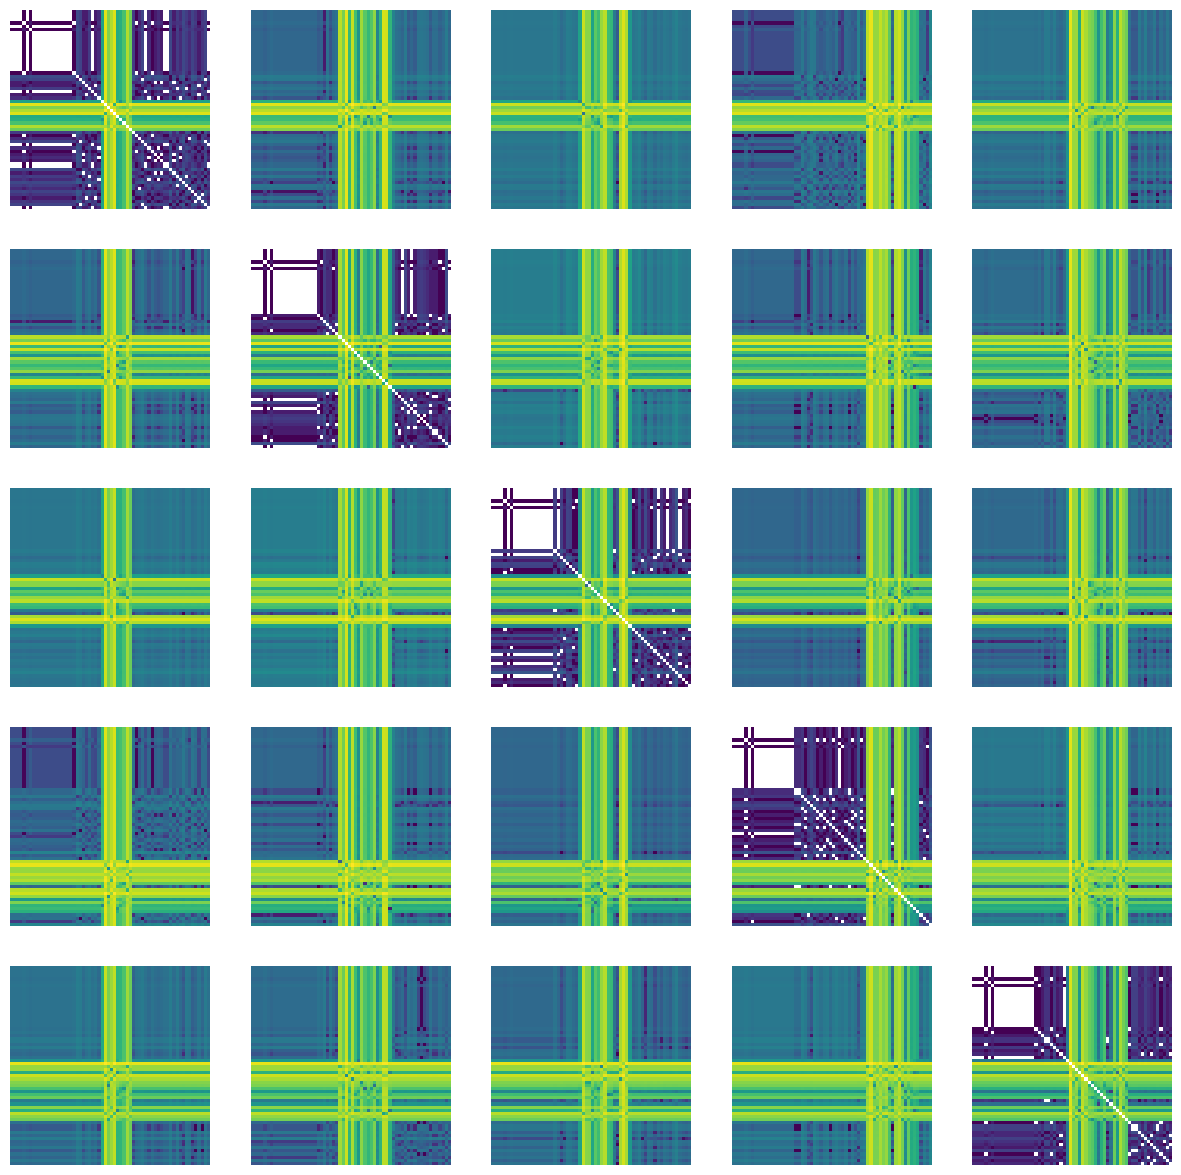

In [74]:
restep = 100
fig = pl.figure(figsize(15, 15))

for i in range(0,25,5):
    for k, j in enumerate(range(0,25,5)):
        ax = fig.add_subplot(5,5,i + k + 1)
        pl.imshow(np.log10(cdist(np.atleast_2d(X[i][::restep]).T,
                np.atleast_2d(X[j][::restep]).T,
          metric=(lambda x,y: np.abs(x - y)))))
        pl.axis('off');

Figure 6: L1 distance matrices (log₁₀ scale) for all sound bite pairs. Identical diagonals denote self-similarity; bright cross-lines highlight phrase similarities (e.g., "turn on/off"), consistent with Figs. 4-5.

# DTW distance
The DTW algorithm calculates the distance as the sum along a path in the  pair-wise distance matrix that minimized the distance between points, at the cost of increasing the length of the path. The simple Euclidean distance between 2 matrices would be the sum along the diagonal. In DTW this sum is modified to be the sum over the elements as follows:


$DTW(Q_i, C_j) = d(Q_i, C_j) + min(d(Q_{i-1}, C_{j-1}), d(Q_{i-1}, C_j), d(Q_i, C_{j-1})) $
Where $d$ is the distance between 2 time stamps: e.g. the absolute value of thedifference (L1)

The algorithm has the following rules:

- Every index from the first sequence must be matched with one or more indices from the other sequence and vice versa
- The first index from the first sequence must be matched with the first index from the other sequence (but it does not have to be its only match)
- The last index from the first sequence must be matched with the last index from the other sequence (but it does not have to be its only match)
- The mapping of the indices from the first sequence to indices from the other sequence must be monotonically increasing, and vice versa, i.e. if j > i are indices from the first sequence, then there must not be two indices l > k in the other sequence, such that index i is matched with index l and index j is matched with index k , and vice versa

Remember that you will need to start with the L1 distance: at every step you will need to know the L1 distance for several surrounding cells. While you could calculate it on the spot it is more computationally efficient in python to calculate it for the whole array at once, as long as you can store the whole array in memory. Solving this with "dynamic coding", you can calculate all pair-wise distances first, storing the distance matrix, then find the path along the matrix and calculating the DTW distance by looking up values of the relevant cells. Pairwise L1 distance can be caluclated for the entire matrix with ```scipy.spatial.distance.cdist```

With that in mind, create a function that given x and y, two np.arrays of n and m elements respectively, returns
 - the DTW distance
 - the DTW distance matrix
 - the path along the matrix as x-y indices (look in the slides if you need help with this one: I added the code in there)

Make sure your function called *dtw()* and make sure that it has a "docstring' that complies to PEP conventions https://www.python.org/dev/peps/pep-0257/



Run your function for the soundbite arrays using every 100th datapoint and plot the array and the path along the array
 - for the first normalized sound array matched with itself
 - for the first normalized sound array matched with another normalized sound array of the same phrase:  soundbites are the same sentence 5 by 5: 0-4 same sentence, 5-9, 10-14, 15-19, 19-20
 - for the first unnormalized sound array matched with another unnormalized sound array, the same one as in the previous step
 - any two other normalized arrays, not the same sentence.

What is the path for the first array you plotted? Why?

## *task 3: write on your own the DTW algorithm. Use the rules above and the pseudocode and equations in the slides*

## *Extra Credit: code the DTW with a parameter r tha allows to search farther than one step away from the diagonal. Make that r an input to your dtw() function*

In [75]:

def path(DTWm):
  # the path can be calculated backword or forward
  # I find bacward more intuitive
  # start at one to the last cell:
  i, j = np.array(DTWm.shape) - 2

  #since I do not know how long the path is i will use lists
  # p and q will be the list of indices of the path element along the 2 array axes
  p, q = [i], [j]
  # go all the way to cell 0,0
  while (i > 0) or (j > 0):
      	# pick minimum of 3 surrounding elements:
      	# the diagonal and the 2 surrounding it
        tb = argmin((DTWm[i, j], DTWm[i, j+1], DTWm[i+1, j]))
        #stay on the diagonal
        if tb == 0:
            i -= 1
            j -= 1
        #off diagonal choices: move only up or sideways
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        # put i and the j indexx into p and q pushing existing entries forward
        p.insert(0, i)
        q.insert(0, j)
  return array(p), array(q)



## code steps:
- Calculate the distance matrix according to L1
- Set the 0,0 cell to 0
- for all values of the index i; for all values of the index j

  set the DTW[i,j] cell to $L1 + min(l1(Q_{i-1}, C_{j-1}), L1(Q_{i-1}, C_j), L1(Q_i, C_{j-1}))$

- calculate the DTW path
- return the value of the last cell (DTW[-1,-1])  the DTW array, the path

note: you will likely have to have a nested loop but there are extra points if yuo can figure out how to write it without a nested loop (for i...: for j....:)

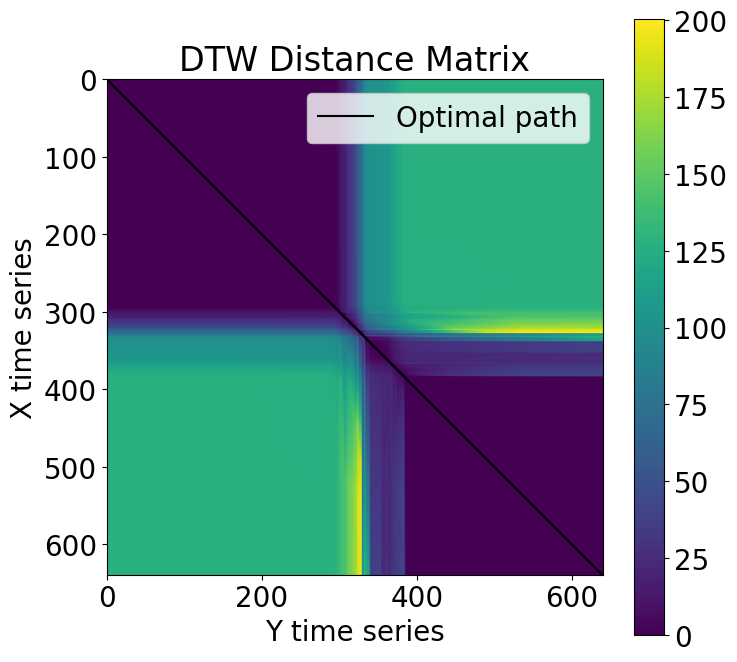

dtw distance:  0.0


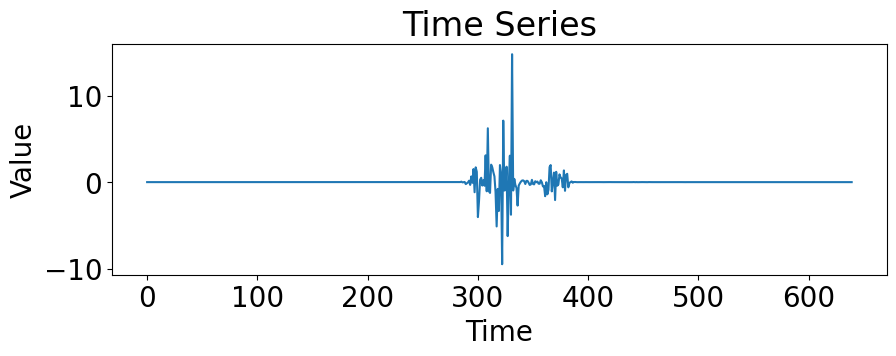

In [96]:
# Dynamic Time Warping implementation based on Yuca Chen's Slack code.

import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

restep = 10

def path(DTW):
    """
    Compute the optimal path through the DTW matrix.

    Args:
        DTW (numpy.ndarray): The DTW distance matrix

    Returns:
        tuple: Lists of indices (i, j) of the optimal path
    """
    i, j = np.array(DTW.shape) - 1
    p, q = [i], [j]

    while i > 0 and j > 0:
        prev_step = np.argmin([DTW[i-1, j-1], DTW[i-1, j], DTW[i, j-1]])

        if prev_step == 0:
            i -= 1
            j -= 1
        elif prev_step == 1:
            i -= 1
        else:
            j -= 1

        p.append(i)
        q.append(j)

    p.reverse()
    q.reverse()

    return np.array(p), np.array(q)

def dtw(x, y, show=False, getpath=True, r=1):
    """
    Returns a DTW matrix along with (optionally) returning a path through the matrix.

    Args:
        x (array or list): x values of elements n
        y (array or list): y values of elements m, corresponding to x values
        show (boolean): show or not show colormap of final DTW computed array
        getpath (boolean): obtain values of the path calculated along the matrix
        r (int): Constraint parameter (not fully implemented in this version)

    Returns:
        If getpath == True:
            tuple: (dtw_distance, dtw_matrix, path_indices)
        If getpath == False:
            float: dtw_distance
    """

    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)

    # Calculate distance matrix
    D = cdist(x, y, metric='cityblock')

    N, M = D.shape
    DTW = np.full((N, M), np.inf)
    DTW[0, 0] = D[0, 0]

    # Fill the DTW matrix
    for i in range(N):
        for j in range(M):
            if i == 0 and j == 0:
                continue  # Skip the first cell as we've already set it

            # Calculate possible values from previous cells
            options = []
            if i > 0:
                options.append(DTW[i-1, j])
            if j > 0:
                options.append(DTW[i, j-1])
            if i > 0 and j > 0:
                options.append(DTW[i-1, j-1])

            # Update current cell
            DTW[i, j] = D[i, j] + min(options)

    # Compute path if requested
    p, q = None, None
    if getpath:
        p, q = path(DTW)

    if show:
        plt.figure(figsize=(8, 8))
        plt.imshow(DTW)
        plt.colorbar()
        plt.title("DTW Distance Matrix")
        if p is not None and q is not None:
            plt.plot(q, p, color='black', label='Optimal path')
            plt.legend()
        plt.xlabel("Y time series")
        plt.ylabel("X time series")
        plt.show()

    if getpath:
        return DTW[-1, -1], DTW, (p, q)
    return DTW[-1, -1]

# Example usage (uncomment when your X data is defined)
# DTW distance to itself
print("dtw distance: ", dtw(X[0][::restep], X[0][::restep], show=True)[0])
pl.figure(figsize=(10,3))
pl.plot(X[0][::restep])
pl.title("Time Series")
pl.xlabel("Time")
pl.ylabel("Value")
pl.show()

Figure 7: DTW distance matrix (top) for identical normalized sound bite subsamples (10th data points) shows a diagonal alignment path (black line) with zero final distance. Color patterns reveal symmetric quadrant similarities (yellow band at x,y≈300) and gradient variations. Overlapping waveforms (bottom) confirm identical inputs.

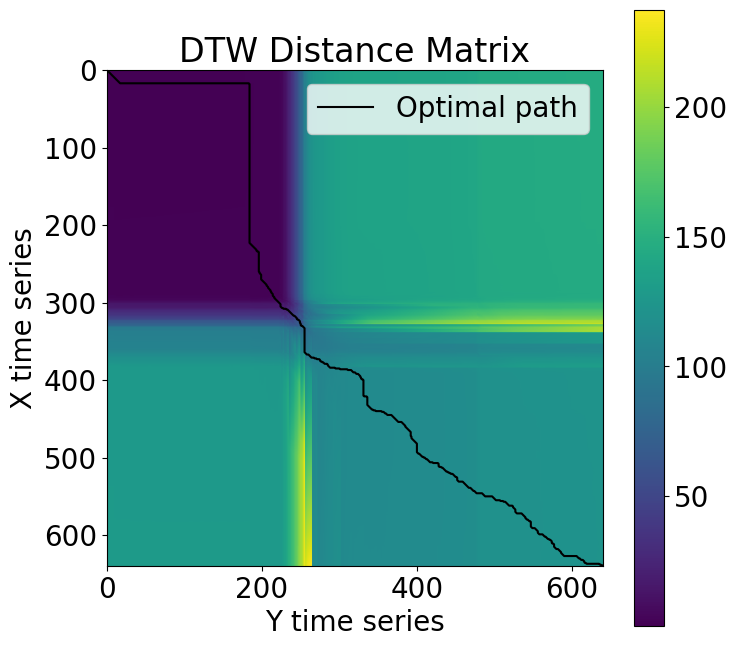

dtw distance:  121.55413980041301


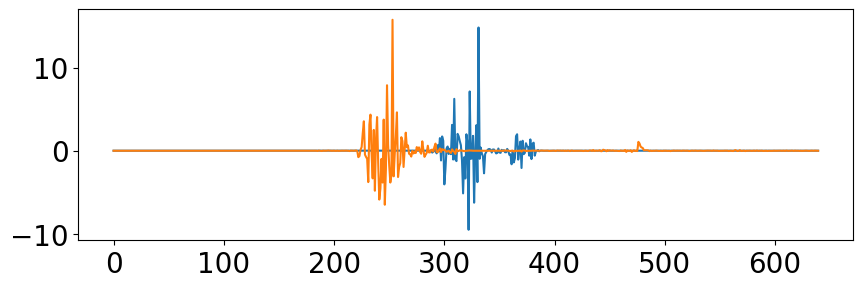

In [97]:
# DTW distance to a file with a different sound bite, normalized
print("dtw distance: ", dtw(X[0][::restep], X[1][::restep], show=True)[0])
pl.figure(figsize(10,3))
pl.plot(X[0][::restep])
pl.plot(X[1][::restep]);

Figure 8: DTW matrix (top) for distinct normalized sound bite subsamples (10th data points) reveals a warped alignment path (black, DTW≈122) with non-diagonal transitions. Matrix features include low-left/high-right quadrant contrasts (yellow band at x,y≈270, bottom-right ~100 distance). Divergent waveforms (bottom) illustrate input differences.

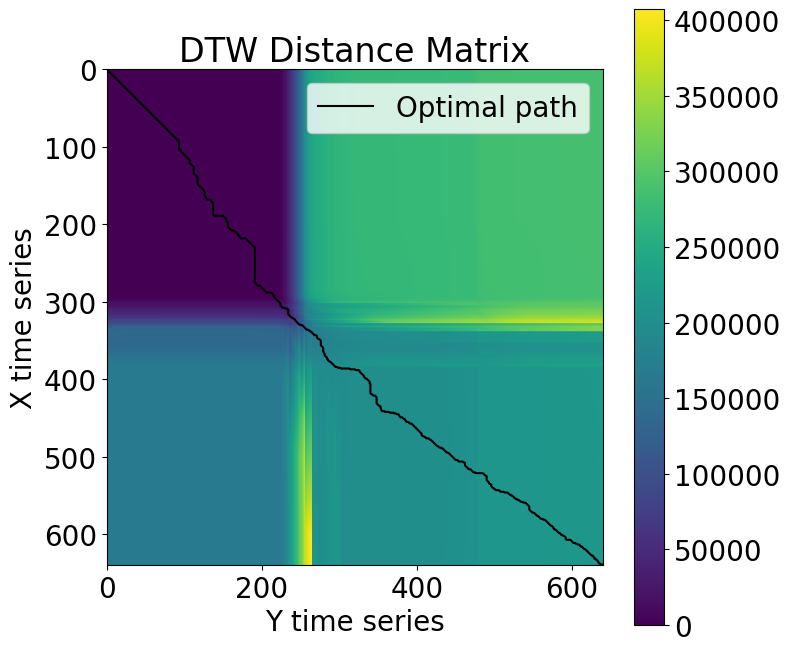

dtw distance:  216485.0


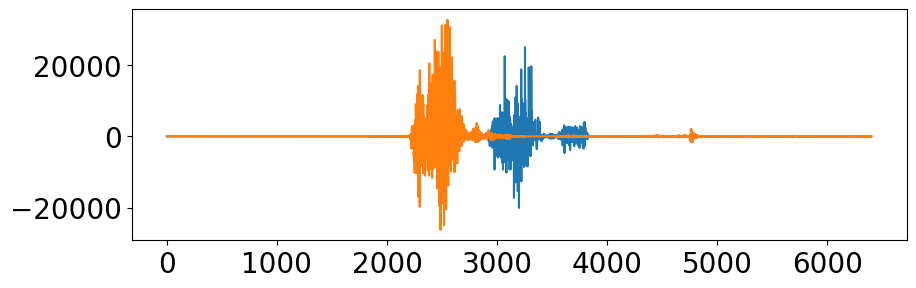

In [100]:
# DTW distance to a file with a different sound bite, normalized
print("dtw distance: ", dtw(wavfiles[0][::steps*restep], wavfiles[1][::steps*restep], show=True)[0])
pl.figure(figsize(10,3))
pl.plot(wavfiles[0][::restep])
pl.plot(wavfiles[1][::restep]);

Figure 9: Unnormalized DTW matrix (top) exhibits larger scale magnitude (DTW≈216k) and altered alignment path (vs Fig. 8), with diagonal shift in top-left quadrant. Colormap shows distinct quadrant contrasts (yellow band at x,y≈250). Non-overlapping waveforms (bottom) reflect raw amplitude differences.

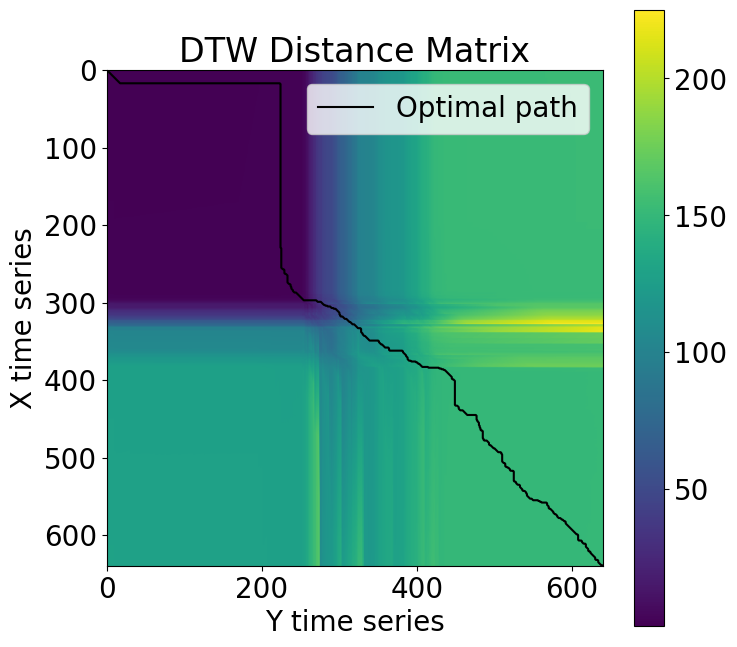

dtw distance:  150.50888976161608


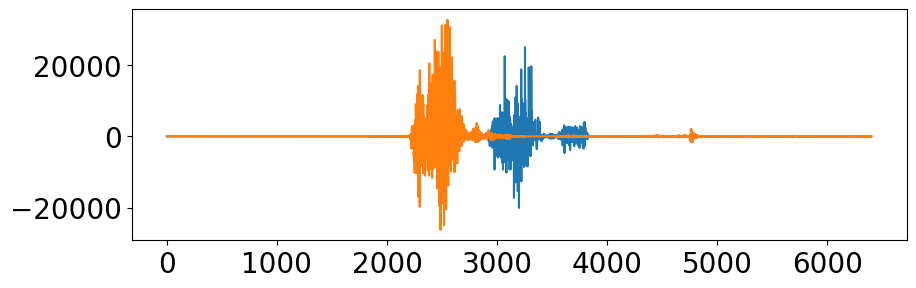

In [101]:
# DTW distance to a file with a different sound bite
print("dtw distance: ", dtw(X[0][::restep], X[24][::restep], show=True)[0])
pl.figure(figsize(10,3))
pl.plot(wavfiles[0][::restep])
pl.plot(wavfiles[1][::restep]);

Figure 10: DTW matrix (top) for distinct unnormalized sound bites (DTW≈151) shows a unique cross pattern and y≈270 yellow band, with 10³ lower magnitude than Fig. 9. Alignment path reveals distinct time warping vs earlier figures. Partial waveform overlap (bottom) suggests partial similarity despite raw amplitude differences.

# 2 What is the nearest neighbor of the first sound bite?

In [102]:
# what is most similar to the first time series? (other than itself)
distances = np.zeros(25) * np.nan
for i in range(25):
    print(i, "/25")
    distances[i], _, _ = dtw(X[0][::restep], X[i][::restep]);


0 /25
1 /25
2 /25
3 /25
4 /25
5 /25
6 /25
7 /25
8 /25
9 /25
10 /25
11 /25
12 /25
13 /25
14 /25
15 /25
16 /25
17 /25
18 /25
19 /25
20 /25
21 /25
22 /25
23 /25
24 /25


In [103]:

distances.argsort()

array([ 0,  3,  2,  1, 24, 13,  4,  5,  8, 22, 19, 15,  6, 16, 11, 12, 18,
        7,  9, 17, 10, 14, 23, 20, 21])

In [104]:
print("Based on its nearest neighbor the first sound bite says...")
print(y[distances.argsort()[1]])

Based on its nearest neighbor the first sound bite says...
Jarvis


## *task 4: Classify the 20th sound bite based on its nearest neighor with Euclidean and DTW distance*

In [105]:
# what is most similar to the first time series? (other than itself)
distancesE = np.zeros(25) * np.nan
for i in range(25):
    print(i, "/25")
    distancesE[i] = euclidean(X[19], X[i]);



0 /25
1 /25
2 /25
3 /25
4 /25
5 /25
6 /25
7 /25
8 /25
9 /25
10 /25
11 /25
12 /25
13 /25
14 /25
15 /25
16 /25
17 /25
18 /25
19 /25
20 /25
21 /25
22 /25
23 /25
24 /25


In [106]:
distancesE.argsort()

array([19,  0, 11, 18,  8, 12,  6, 16,  2, 14, 22,  3, 17, 21,  1,  4, 13,
        9, 10, 15,  5, 23, 24, 20,  7])

In [109]:
print("Based on its nearest neighbor and Euclidian distance ",
      "the last sound bite says...")
print(y[distancesE.argsort()[1]])
print("Correct!") if y[distancesE.argsort()[1]] == y[19] else print("Sorry...")

Based on its nearest neighbor and Euclidian distance  the last sound bite says...
Jarvis
Sorry...


In [110]:
# what is most similar to the first time series? (other than itself)
distancesDTW = np.zeros(25) * np.nan
for i in range(25):
    print(i, "/25")
    distancesDTW[i] = dtw(X[19][::steps], X[i][::steps], getpath=False);

0 /25
1 /25
2 /25
3 /25
4 /25
5 /25
6 /25
7 /25
8 /25
9 /25
10 /25
11 /25
12 /25
13 /25
14 /25
15 /25
16 /25
17 /25
18 /25
19 /25
20 /25
21 /25
22 /25
23 /25
24 /25


In [111]:
print("Based on its nearest neighbor and DTW distance ",
      "the last sound bite says...")
print(y[distancesDTW.argsort()[1]])
print("Correct!") if y[distancesDTW.argsort()[1]] == y[19] else print("Sorry...")

Based on its nearest neighbor and DTW distance  the last sound bite says...
Tofftl
Sorry...
